In [1]:
### MASTER_Script_python3
'''
This is MASTER_Script_python3 for evaluation of FESOM2-REcoM output. 
Adapted from py_recom/GlobalAssesment/MASTER_Script.ipynb

Please install:
-pyfesom2
-skillmetrics
-cartopy

Caution: As basemap gets deprecated, pyfesom2 (thus, this sript as well) use cartopy instead. 
Using Robinson projection needs more time than the standard Plate Carree projection.

Tracers are calculated at midlayer depths, c.f. https://fesom2.readthedocs.io/en/latest/geometry.html
'''

'\nThis is MASTER_Script_python3 for evaluation of FESOM2-REcoM output. \nAdapted from py_recom/GlobalAssesment/MASTER_Script.ipynb\n\nPlease install:\n-pyfesom2\n-skillmetrics\n-cartopy\n\nCaution: As basemap gets deprecated, pyfesom2 (thus, this sript as well) use cartopy instead. \nUsing Robinson projection needs more time than the standard Plate Carree projection.\n\nTracers are calculated at midlayer depths, c.f. https://fesom2.readthedocs.io/en/latest/geometry.html\n'

In [2]:
%matplotlib inline
%autosave 5

Autosaving every 5 seconds


In [3]:
# necessary modules -------------------------------------------------------------------------------------
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import time
from datetime import date

#import sys
#sys.path.append('home/ollie/mozeisin/SkillMetrics')

#import cartopy.crs as ccrs
#import pangaeapy.pandataset as pd

# own py_recom modules ----------------------------------------------------------------------
!jupyter nbconvert --to=python load_interp_WOA_python3.ipynb
!jupyter nbconvert --to=python plot_Taylor_normalized.ipynb

#from load_interp_WOA_python3 import WOAdata
#from plot_Taylor_normalized import plt_Taylor_norm

[NbConvertApp] Converting notebook load_interp_WOA_python3.ipynb to python
[NbConvertApp] Writing 17424 bytes to load_interp_WOA_python3.py
[NbConvertApp] Converting notebook plot_Taylor_normalized.ipynb to python
[NbConvertApp] Writing 2548 bytes to plot_Taylor_normalized.py


In [4]:
# After changing these parameters here, save the notebook and clear the output. 
# Then run this cell and the cells with the desired parameters.

# run specification -------------------------------------------------------------------------------------
if False:
    runid      =  'fesom'
    layerwise    = False
    resultpath = '/work/ollie/mozeisin/results/f2r1.2/20201015_tep_test' 
    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

    # period of analysis 
    first_year = 1949
    last_year  = 1950
    
if False:    
    runid = 'fesom'
    layerwise = False
    resultpath = '/work/ollie/ogurses/output_f2r2/THIRD_RUN'
    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'
    
    # period of analysis 
    first_year = 2000
    last_year  = 2007
    
if True:
    runid      =  'fesom'
    layerwise    = False
    resultpath = '/work/ollie/mozeisin/results/f2r1.2/mo5'
    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

    # period of analysis 
    first_year = 1952
    last_year  = 1957
    
years = [first_year, last_year]

# specification of analysis ------------------------------------------------------------------------------------
depth = 0
layerwise = False
mapproj = 'pc'
#Map projection. Options are Mercator (merc), Plate Carree (pc),
#North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
#Robinson projection is quite time consuming.

# export of analysis ------------------------------------------------------------------------------------
today = date.today().strftime("_%Y_%m_%d")

savepath = '/home/ollie/mozeisin/evaluation/mo_files/mo5/'
savefig = True
htmlname     =  'mo5_' + runid + today +'.html'
htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'

# initialization file specifications -----------------------------------------------------------

obspath      = '/home/ollie/mseifert/py_fesom/CreateRunFiles/Initialization/Output/'

ncfileAlk                = '/work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TAlk.nc'
ncfileDIC                = '/work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TCO2.nc'
ncfileDSi                = '/work/ollie/projects/MarESys/evaluation/woa13_all_i00_01.nc'
ncfileDIN                = '/work/ollie/projects/MarESys/evaluation/woa13_all_n00_01.nc'
ncfileDO2                = '/work/ollie/projects/MarESys/evaluation/woa18_all_o00_01.nc'
ncfileDFe                = '/work/ollie/projects/MarESys/evaluation/fe_pisces_opa_eq_init_3D.nc' 
ncfileNPPTotalGlobal     = '/work/ollie/projects/MarESys/evaluation/'+'fesom.initial.mesh.diag.nc'
ncfileCO2fluxTotalGlobal = '/work/ollie/projects/MarESys/evaluation/'+'fesom.initial.mesh.diag.nc'
ncfileTemp               = '/work/ollie/projects/MarESys/evaluation/woa18_decav_t00_01.nc'
ncfileSal                = '/work/ollie/projects/MarESys/evaluation/woa18_decav_s00_01.nc'
ncfilepCO2               = '/work/ollie/projects/MarESys/evaluation/SOCATv6_tracks_gridded_monthly.nc'
ncfileMLD                = '/work/ollie/projects/MarESys/evaluation/mld_DR003.nc'
matfileChlsurf           = '/work/ollie/projects/MarESys/evaluation/climatology_annual_chl_1deg_OCCCI_2012_2015.mat'
txtfileCO2flux           = '/work/ollie/projects/MarESys/evaluation/CO2_flux2015_Takahashietal2009_original.txt'


In [5]:
# mesh initialization -----------------------------------------------------------
mesh = pf.load_mesh(meshpath)

if False: # check mesh setup nodal and area
    meshdiag=resultpath+'/'+runid+'.mesh.diag.nc'
    !ncdump -h $meshdiag

    diag = pf.get_meshdiag(mesh,meshdiag=meshdiag, runid=runid)
    #print(diag)
    #print(diag['Z']) # depth of layers
    mesh_depths = diag['Z'].values
    #print(mesh_depths)
    
    nod_area = diag.rename_dims({"nl": "nz1", "nod_n": "nod2"}).nod_area
    nod_area.load()
    #print(np.shape(nod_area[:,:]), type(nod_area))
    
if False:    
    # whole globe
    pf.plot(mesh,np.array(nod_area[0,:]),units='Surface nodal area')
    
    # plot nodal area and mesh structure together
    pf.tplot(mesh, np.array(nod_area[0,:]), ptype='tri', box=[-30, 30, 60, 82], mapproj='np',lw=0.5,units='nodal area')
    pf.tplot(mesh, np.array(nod_area[0,:]), ptype='tri', box=[-30, 30, -30, 30], mapproj='merc',lw=0.5,units='nodal area')

# Physical fields

[NbConvertApp] Converting notebook Temp_WOA_Comparison_python3.ipynb to python
[NbConvertApp] Writing 12394 bytes to Temp_WOA_Comparison_python3.py
***
Loading WOA file: /work/ollie/projects/MarESys/evaluation/woa18_decav_t00_01.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***

Plotting Temperature as mean over depth
FESOM min = -0.8558717966079712, max = 13.561275482177734
WOA min = -0.8918370845470023, max = 13.40603570735201


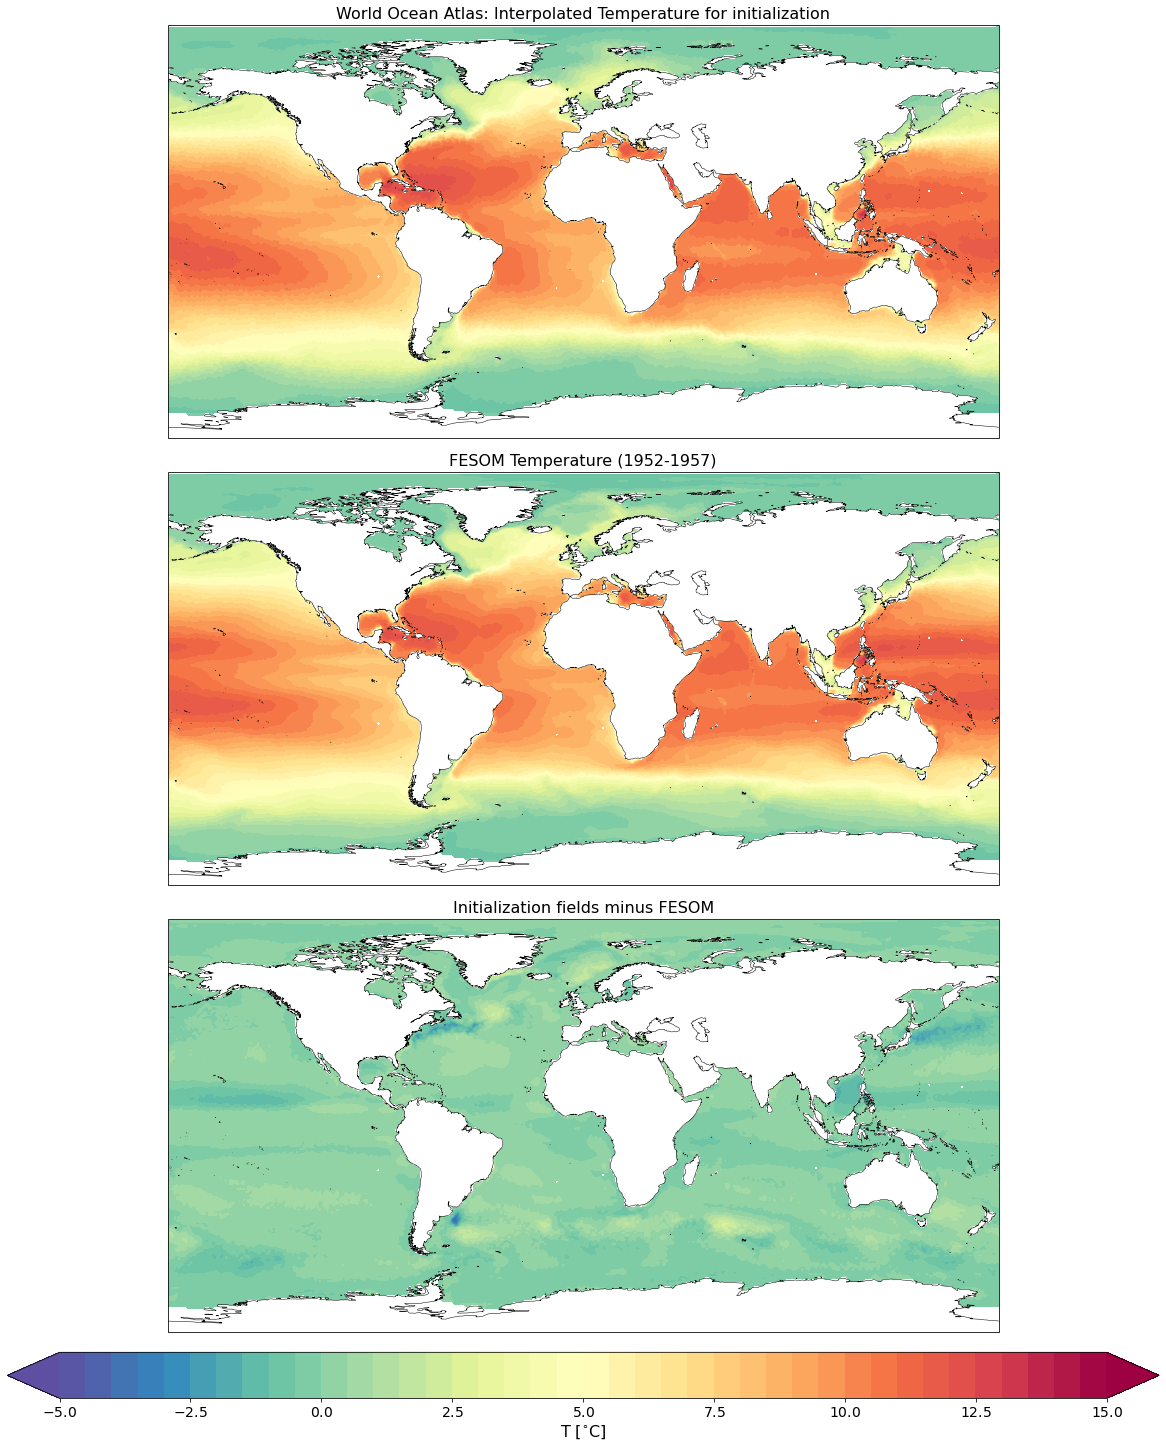

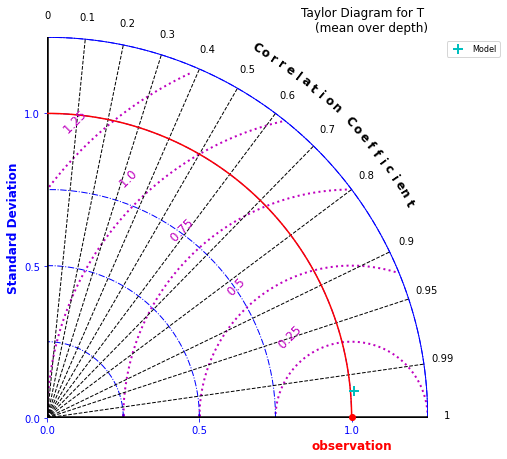

In [6]:
!jupyter nbconvert --to=python Temp_WOA_Comparison_python3.ipynb

from Temp_WOA_Comparison_python3 import TEMPcomp
test = TEMPcomp(runid,resultpath,savepath,meshpath,ncfileTemp,first_year,last_year,mapproj=mapproj,savefig=savefig)


In [7]:
# !jupyter nbconvert --to=python Temp_WOA_Comparison_30W.ipynb
# from Temp_WOA_Comparison_30W import Temp_WOA_30W
# Test = Temp_WOA_30W(runname,resultpath,savepath,modulepath,meshpath,first_year,last_year,mesh_id,ncfileTemp)
# Test.plot()

[NbConvertApp] Converting notebook Sal_WOA_Comparison_python3.ipynb to python
[NbConvertApp] Writing 13232 bytes to Sal_WOA_Comparison_python3.py
***
Loading WOA file: /work/ollie/projects/MarESys/evaluation/woa18_decav_s00_01.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***

Plotting Salinity as mean over depth
FESOM min = 0.3711340129375458, max = 35.125370025634766
WOA min = 0.4301358385288969, max = 35.13932475637883


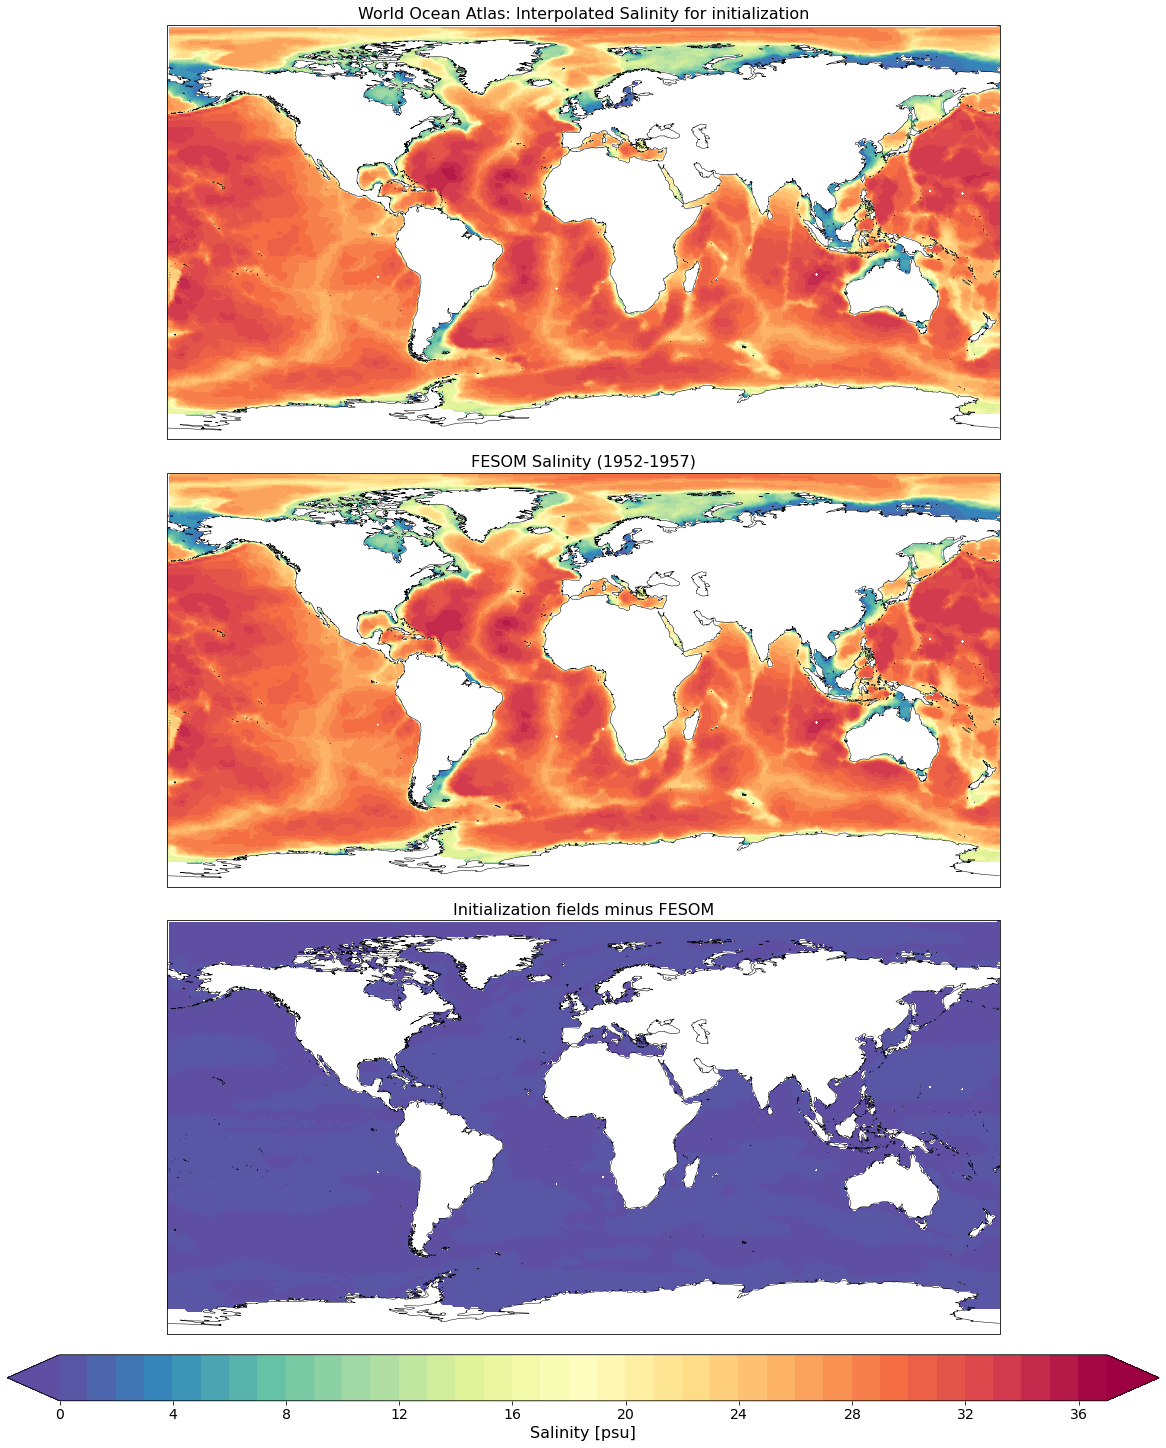

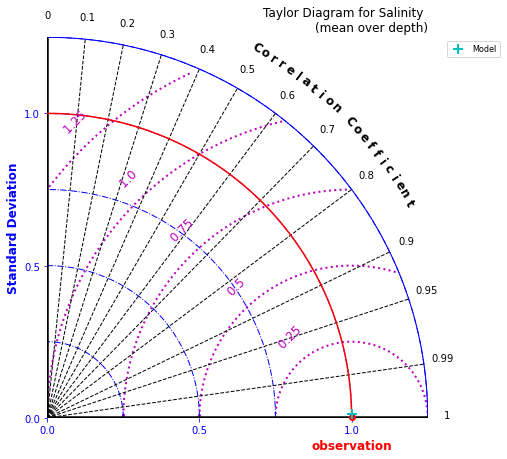

In [8]:
!jupyter nbconvert --to=python Sal_WOA_Comparison_python3.ipynb
from Sal_WOA_Comparison_python3 import SALcomp

#test = SALcomp(runid,resultpath,savepath,meshpath,ncfileSal,first_year,last_year,mapproj=mapproj,savefig=savefig)

# problem: sometimes FESOM salt output (e.g Ozgur's testrun 3) includes all gridpoints in deeper depth and not only ocean points!
# solution: load FESOM temp output additionally to use it as mask
test = SALcomp(runid,resultpath,savepath,meshpath,ncfileSal,first_year,last_year,
               get_overview = False,
               use_temp_mask = True,
               mapproj=mapproj,
               layerwise=False,savefig=savefig)

[NbConvertApp] Converting notebook MLDspatial_python3.ipynb to python
[NbConvertApp] Writing 5048 bytes to MLDspatial_python3.py
*** Using MLD2 (Monterey and Levitus, 1997). ***


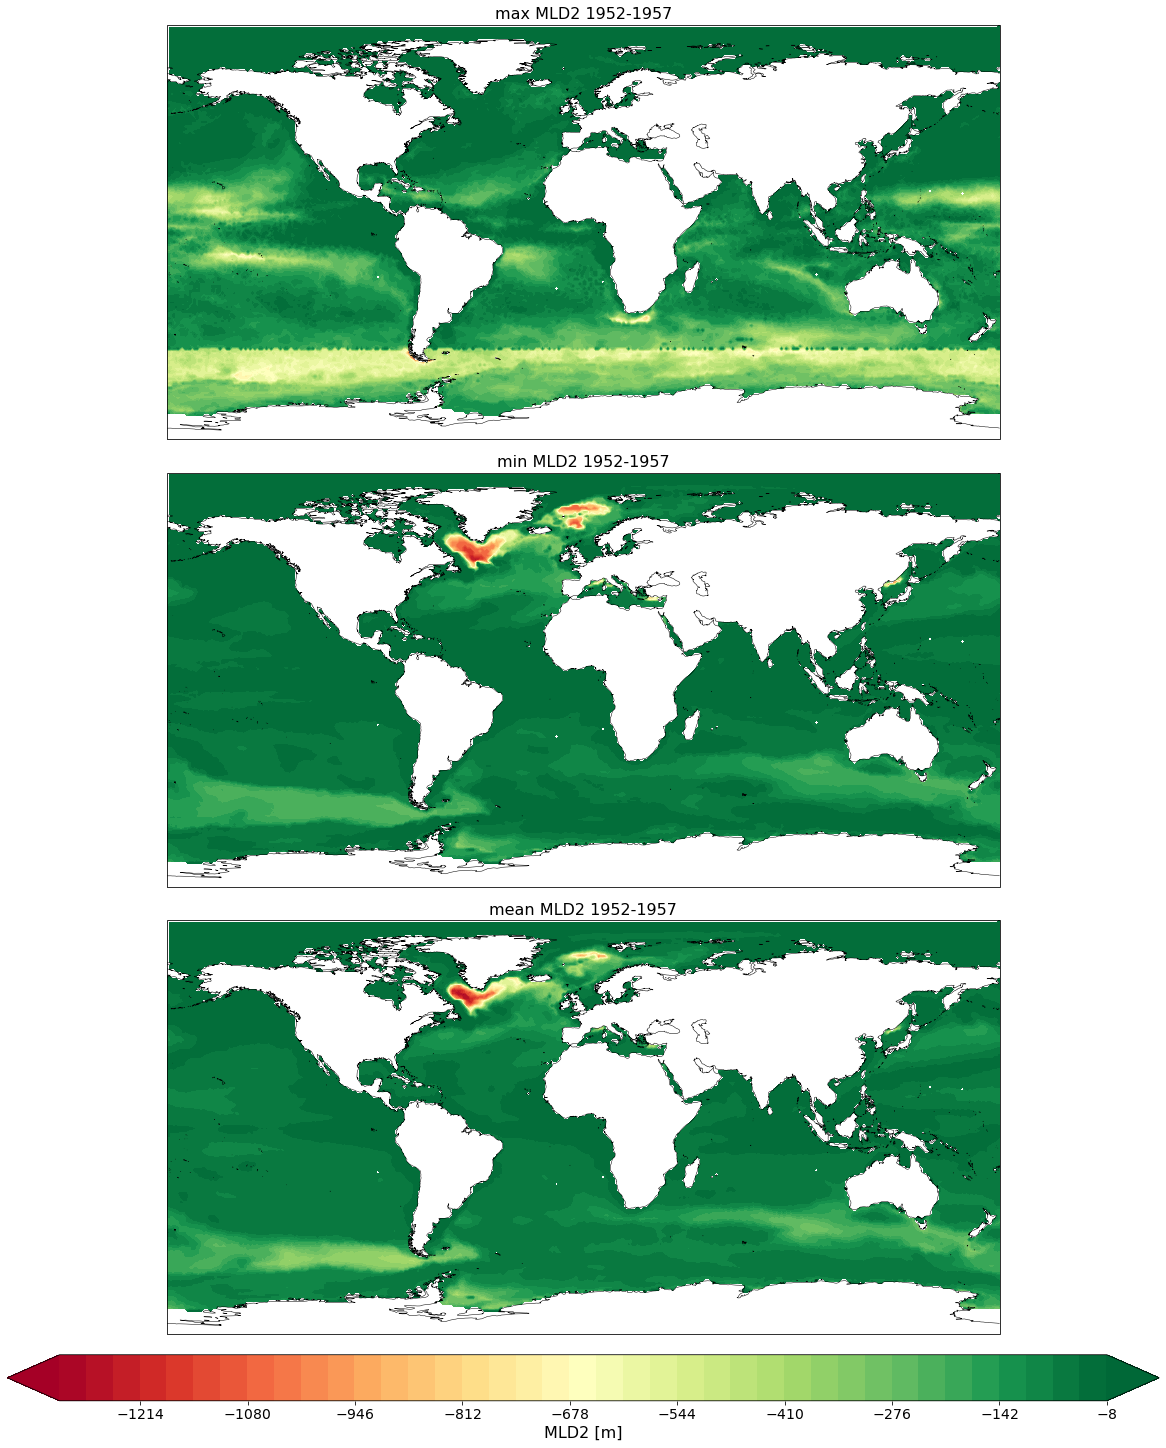

"\nCalculate mixed layer depth after Monterey and Levitus, (1997) who \ncompute MLD as the depth at which the density over depth differsby 0.125 sigma units \nfrom the surface density (Griffies et al., 2009). \nThis MLD definition was also supported in FESOM1.4 (-->MLD2) \n\nDefinition of Large et al. (1997), who suggest to compute MLD\nas the shallowest depth where the vertical derivative of buoyancy\nis equal to a local critical buoyancy gradient (Griffies et al., 2009) (-->MLD1).\n\nC.f. oce_ale_pressure_bv.F90\n\ncomp. to FESOM 1.4: \n'mlotst'  : mixed layer depth [m], computed with Levitus method (with 0.125 kg/m3 criterion)\n'omldamax': daily maximum ocean mixed layer thickness [m] defined by mixing scheme\n"

In [9]:
!jupyter nbconvert --to=python MLDspatial_python3.ipynb
from MLDspatial_python3 import MLDspatial_global

test = MLDspatial_global(runid,resultpath,savepath,meshpath,first_year,last_year,mapproj=mapproj,savefig=savefig)
    
'''
Calculate mixed layer depth after Monterey and Levitus, (1997) who 
compute MLD as the depth at which the density over depth differsby 0.125 sigma units 
from the surface density (Griffies et al., 2009). 
This MLD definition was also supported in FESOM1.4 (-->MLD2) 

Definition of Large et al. (1997), who suggest to compute MLD
as the shallowest depth where the vertical derivative of buoyancy
is equal to a local critical buoyancy gradient (Griffies et al., 2009) (-->MLD1).

C.f. oce_ale_pressure_bv.F90

comp. to FESOM 1.4: 
'mlotst'  : mixed layer depth [m], computed with Levitus method (with 0.125 kg/m3 criterion)
'omldamax': daily maximum ocean mixed layer thickness [m] defined by mixing scheme
'''

In [10]:
## oxygen

[NbConvertApp] Converting notebook DO2_WOA_Comparison_python3.ipynb to python
[NbConvertApp] Writing 12605 bytes to DO2_WOA_Comparison_python3.py
***
Loading WOA file: /work/ollie/projects/MarESys/evaluation/woa18_all_o00_01.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***

Plotting DO2 as mean over depth
FESOM min = 10.654544830322266, max = 266.1380615234375
WOA min = 12.575189468708444, max = 270.6514697785073


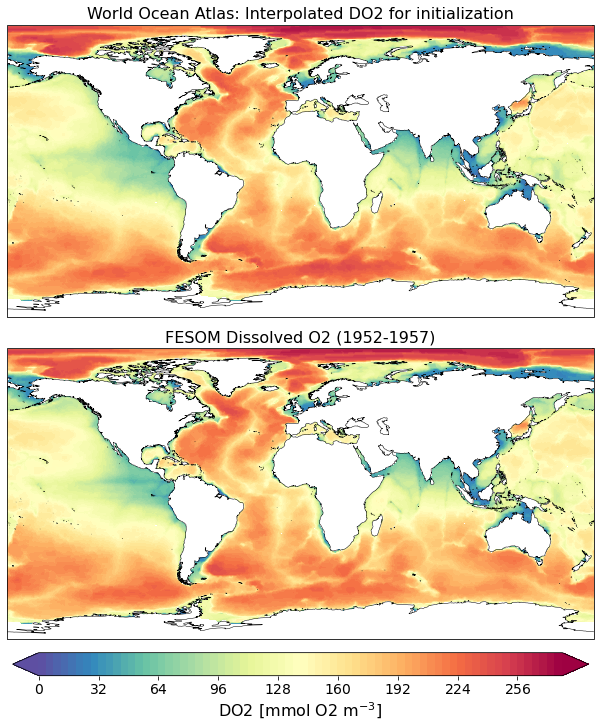

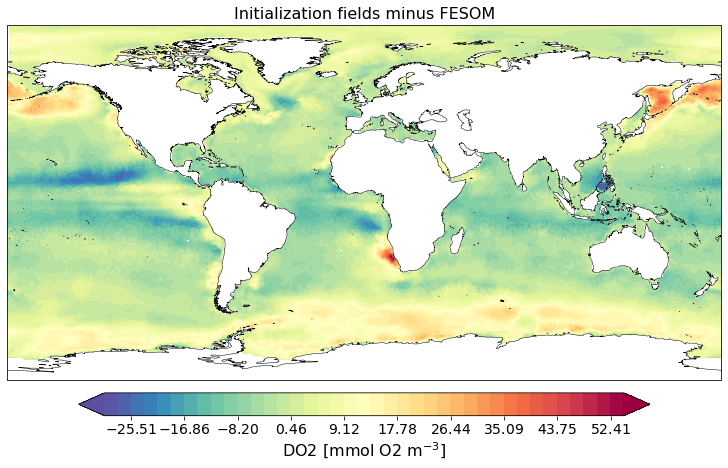

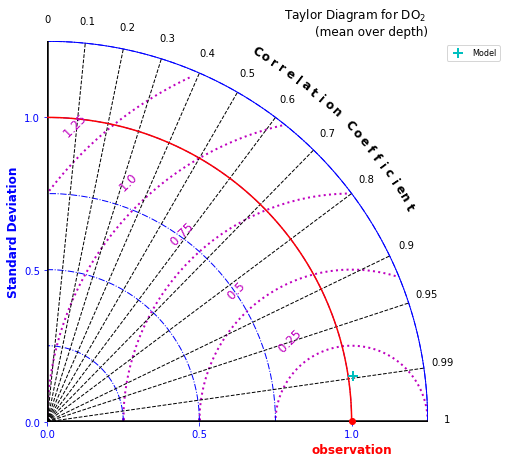

In [11]:
!jupyter nbconvert --to=python DO2_WOA_Comparison_python3.ipynb
from DO2_WOA_Comparison_python3 import DO2comp

test = DO2comp(runid,resultpath,savepath,meshpath,ncfileDO2,first_year,last_year,
               mapproj=mapproj,layerwise=False,savefig=savefig)

# Nutrients

[NbConvertApp] Converting notebook DIN_WOA_Comparison_python3.ipynb to python
[NbConvertApp] Writing 12248 bytes to DIN_WOA_Comparison_python3.py
***
Loading WOA file: /work/ollie/projects/MarESys/evaluation/woa13_all_n00_01.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***

Plotting DIN as mean over depth
FESOM min = 0.0048929499462246895, max = 34.6171989440918
WOA min = 0.0005629408827170412, max = 34.985260415584484


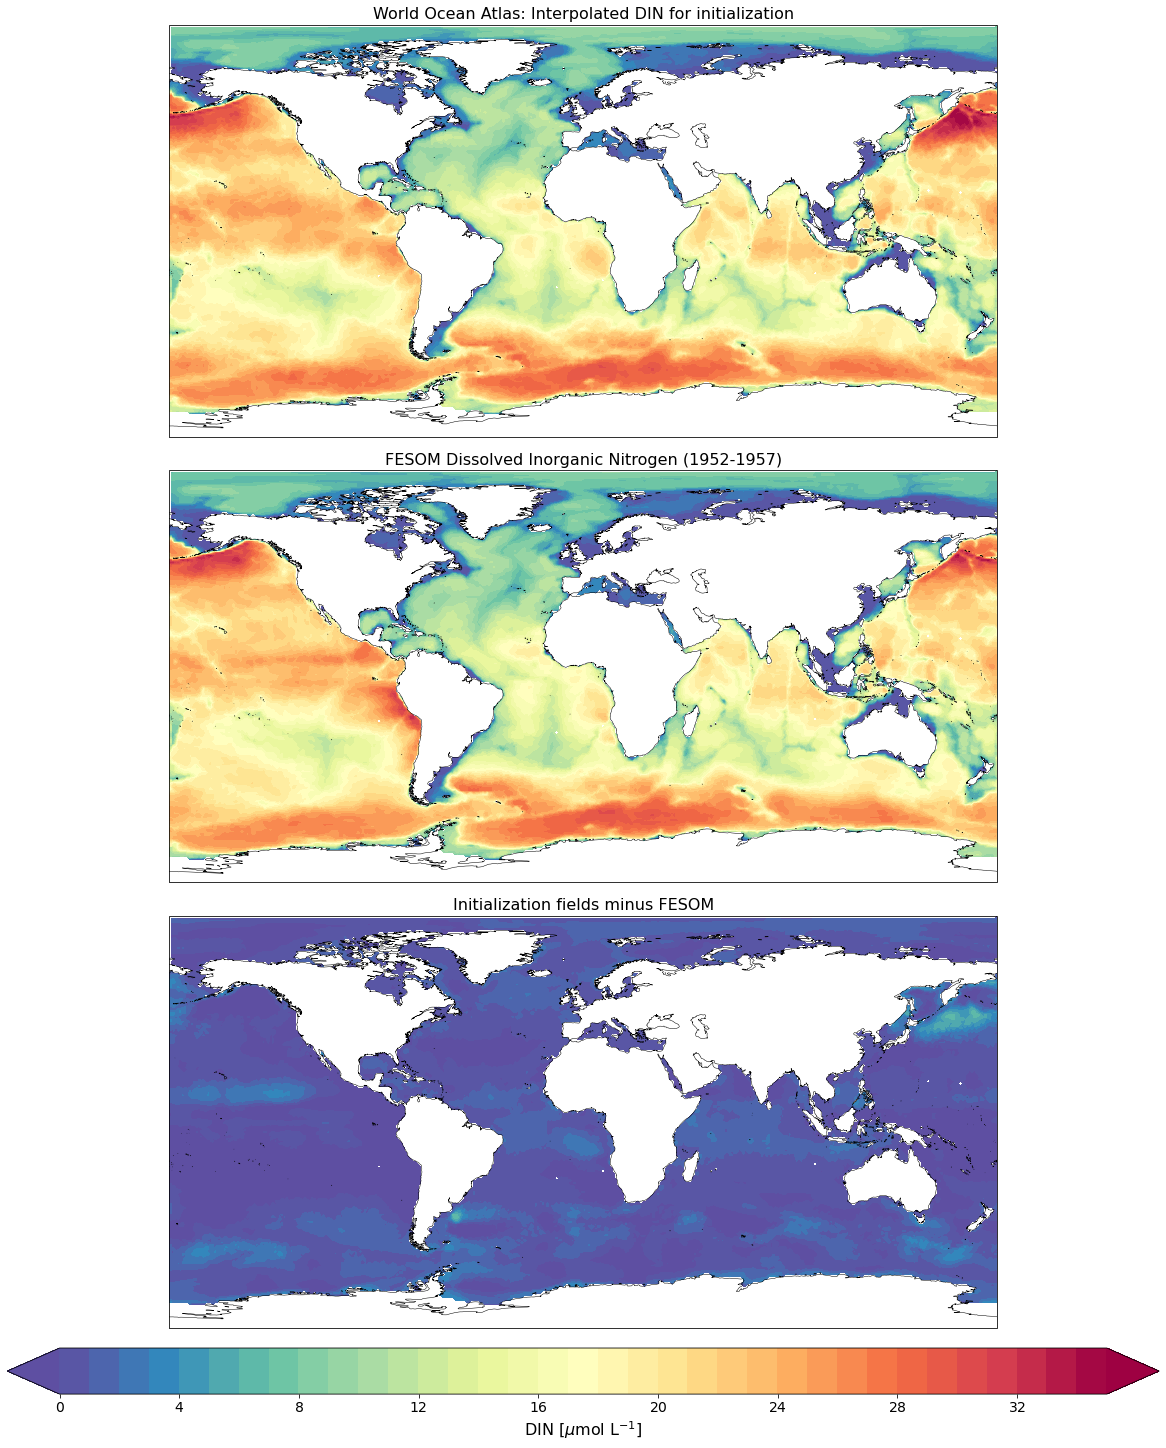

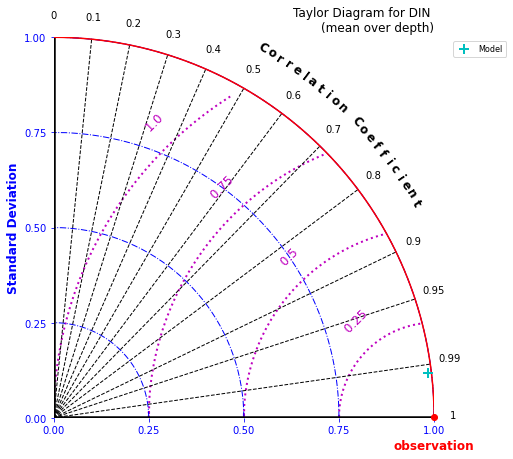

In [12]:
!jupyter nbconvert --to=python DIN_WOA_Comparison_python3.ipynb

from DIN_WOA_Comparison_python3 import DINcomp
test = DINcomp(runid,resultpath,savepath,meshpath,ncfileDIN,first_year,last_year,mapproj=mapproj,savefig=savefig)


[NbConvertApp] Converting notebook DSi_WOA_Comparison_python3.ipynb to python
[NbConvertApp] Writing 12928 bytes to DSi_WOA_Comparison_python3.py
***
Loading WOA file: /work/ollie/projects/MarESys/evaluation/woa13_all_i00_01.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***

Plotting DSi as mean over depth
FESOM min = 0.0001756483834469691, max = 117.9854965209961
WOA min = 0.05886279395286073, max = 115.39271837599735


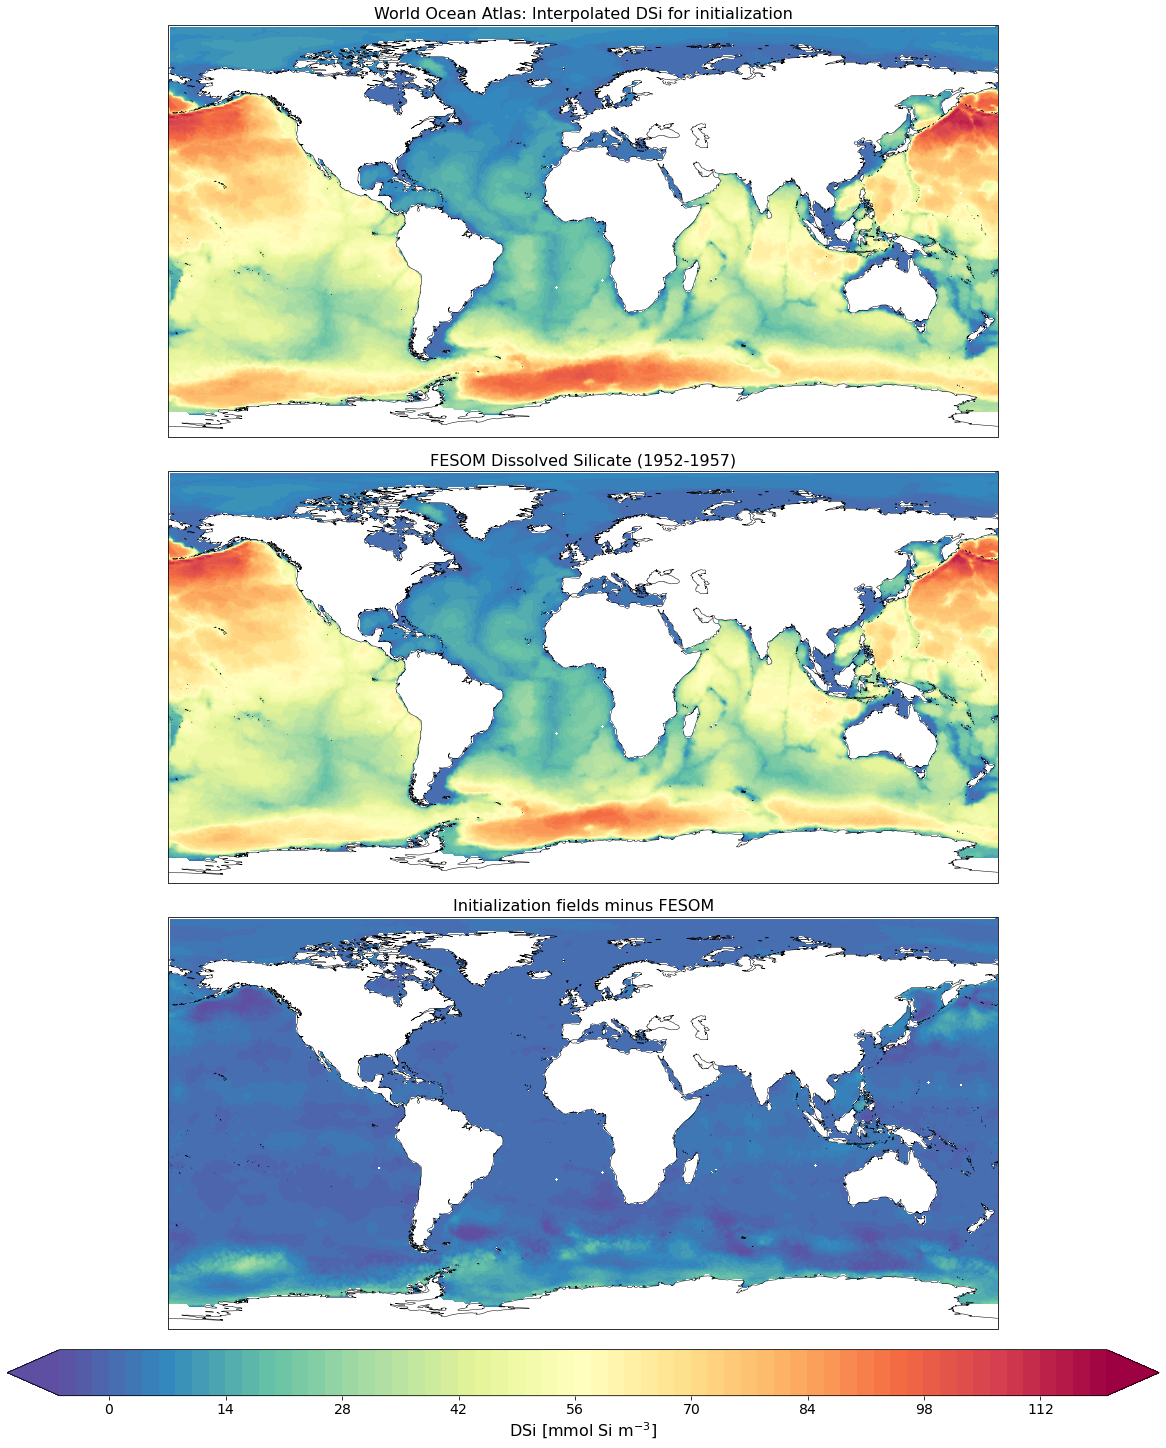

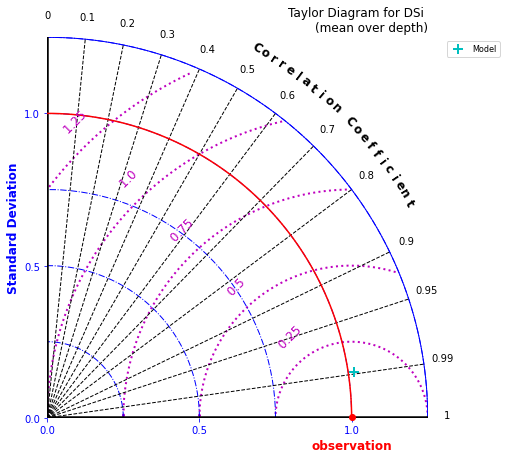

In [13]:
!jupyter nbconvert --to=python DSi_WOA_Comparison_python3.ipynb
from DSi_WOA_Comparison_python3 import DSicomp

test = DSicomp(runid,resultpath,savepath,meshpath,ncfileDSi,first_year,last_year,mapproj=mapproj,savefig=True)

***
Loading WOA file: /work/ollie/projects/MarESys/evaluation/woa13_all_i00_01.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***

Input depth = 0, plotting at depth = -2.5 m
FESOM min = 0.0010776519775390625, max = 37.11204147338867
WOA min = 0.41220349073410034, max = 96.04905700683594


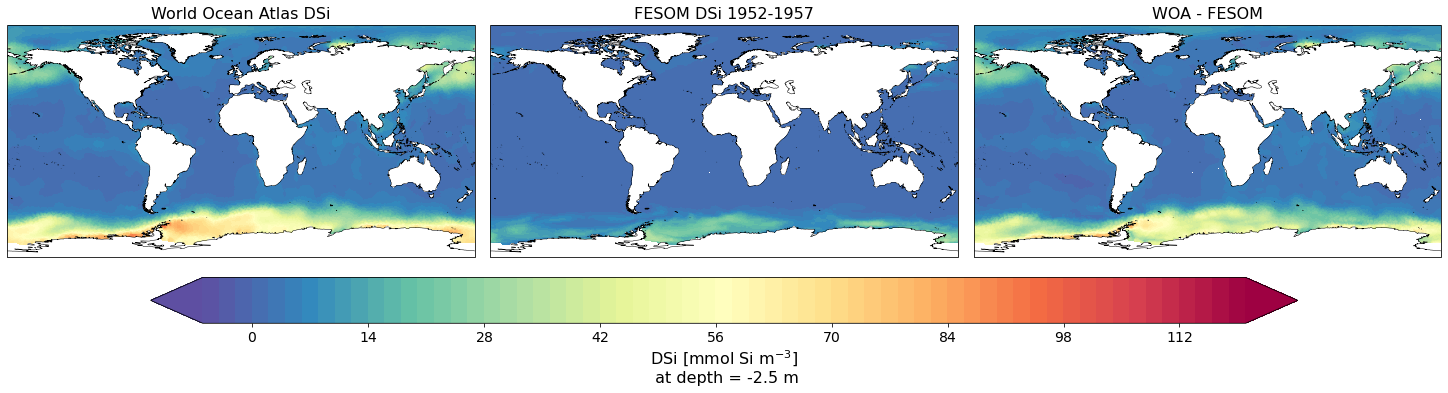


Input depth = 1000, plotting at depth = -1110.0 m
FESOM min = 0.0, max = 179.9827880859375
WOA min = 0.0, max = 177.4405059814453


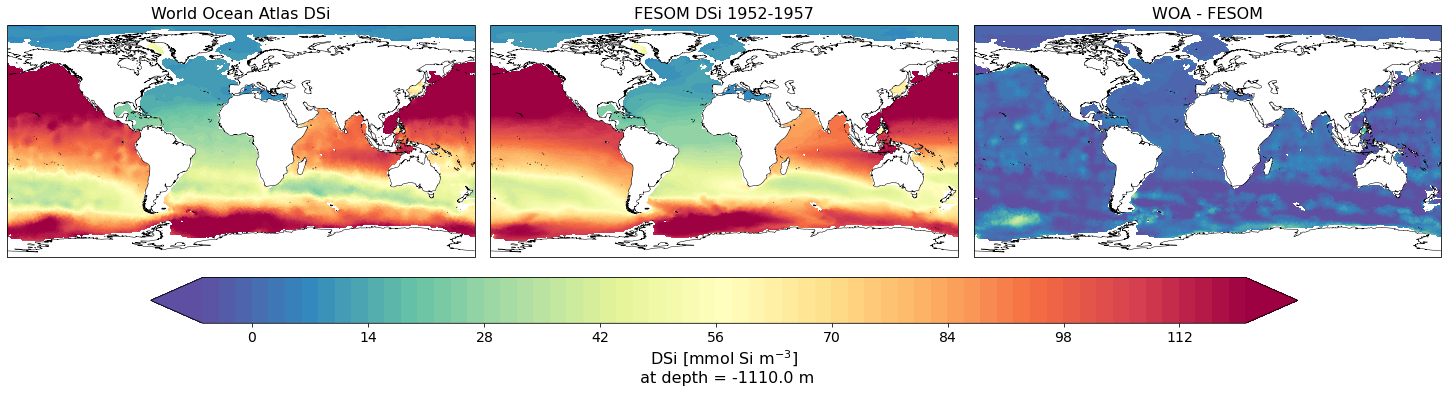


Input depth = 2000, plotting at depth = -2035.0 m
FESOM min = 0.0, max = 194.20790100097656
WOA min = 0.0, max = 219.51812744140625


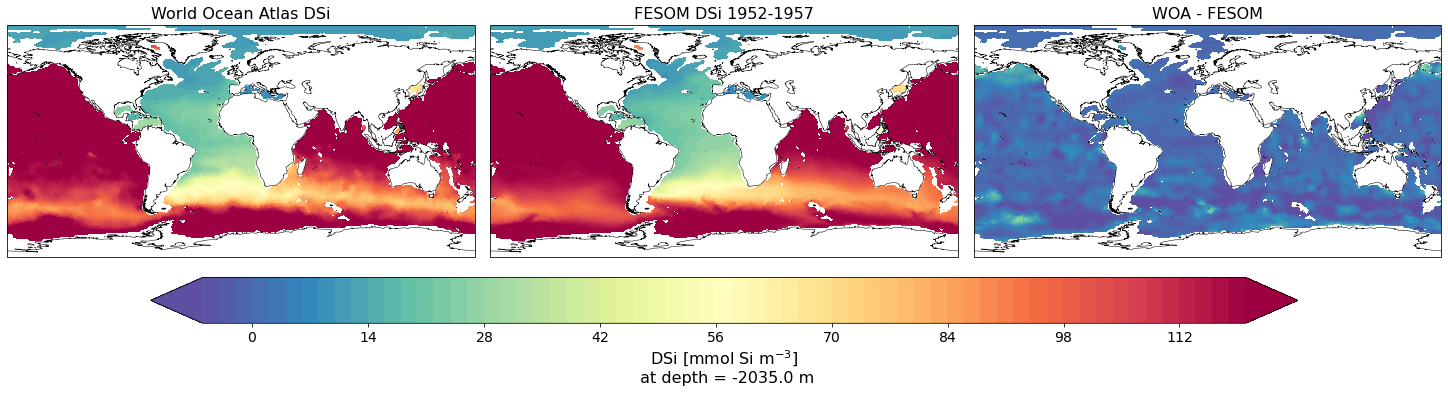

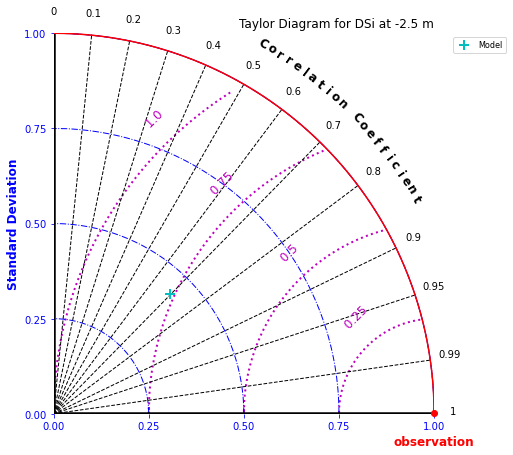

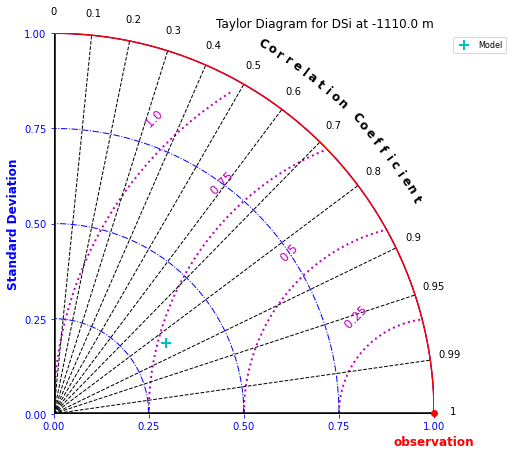

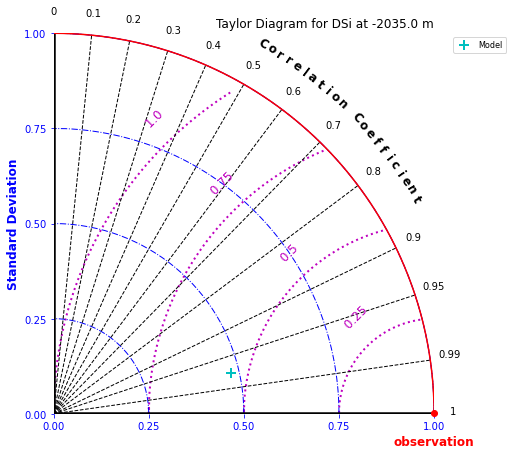

In [14]:
## DSi at three different depth

#from DSi_WOA_Comparison_depth import DSi_WOA_global_depth
#Test = DSi_WOA_global_depth(runname,resultpath,savepath,modulepath,meshpath,first_year,last_year,mesh_id,ncfileDSi)

test = DSicomp(runid,resultpath,savepath,meshpath,ncfileDSi,first_year,last_year,
               layerwise=True, depth_array = [0,1000,2000],
               mapproj=mapproj,savefig=savefig)

[NbConvertApp] Converting notebook DFe_PISCES_Comparison_python3.ipynb to python
[NbConvertApp] Writing 17466 bytes to DFe_PISCES_Comparison_python3.py
***
Depth greater in FESOM (-6125.0) than in PISCES (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***

Plotting DFe as mean over depth
FESOM min = 0.0005880254320800304, max = 2.4582979679107666
PISCES min = 0.0013974910562342786, max = 3208849.386462709


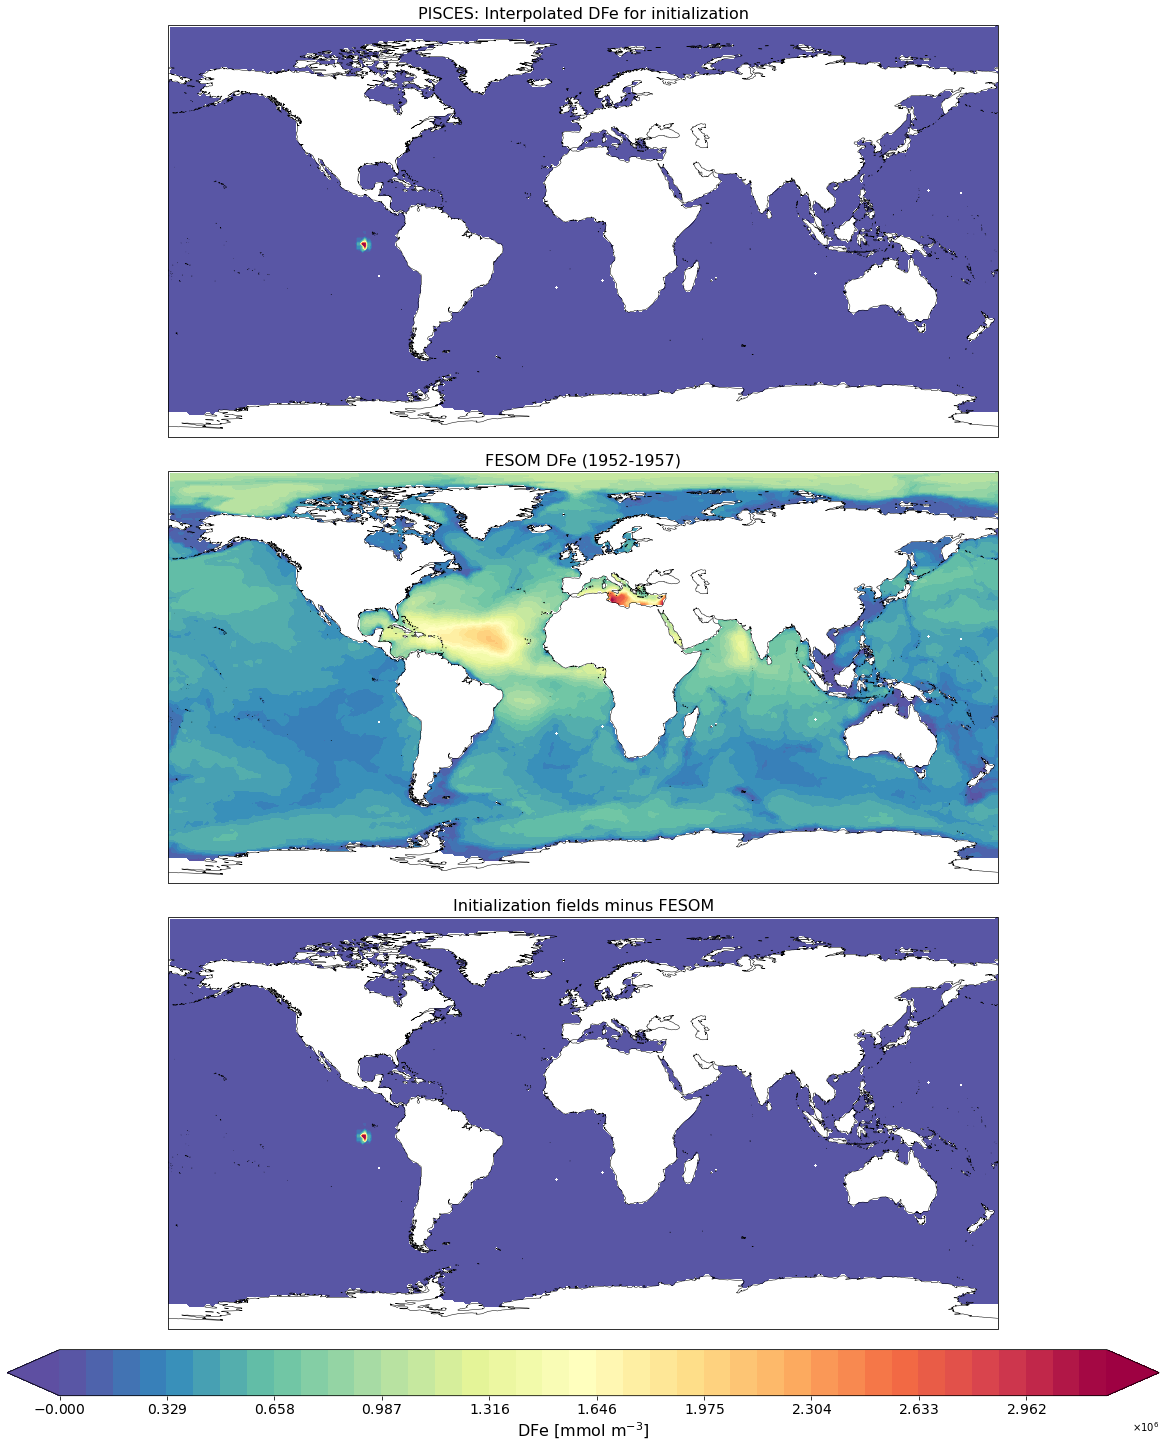

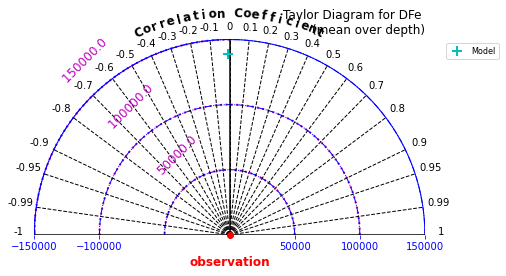

In [15]:
!jupyter nbconvert --to=python DFe_PISCES_Comparison_python3.ipynb
from DFe_PISCES_Comparison_python3 import DFecomp

test = DFecomp(runid,resultpath,savepath,meshpath,ncfileDFe,first_year,last_year,mapproj=mapproj,savefig=savefig)

In [16]:
## Nutrients in Mixed Layer
# --> problem: what is the corresponding FESOM2 output concerning daily max. MLD (omldamax) and mlotst?

#!jupyter nbconvert --to=python Nutrients_MLD.ipynb
#from Nutrients_MLD import nut_mld_prof
#Test = nut_mld_prof(runname,resultpath,savepath,modulepath,meshpath,obspath,ncfileMLD,first_year,last_year)
#Test.plot()

[NbConvertApp] Converting notebook Nutrients_depth_python3.ipynb to python
[NbConvertApp] Writing 21164 bytes to Nutrients_depth_python3.py
Plot at layer depth (diag.Z) instead of level depth (mesh.zlev). 
Better keep layer depth as scalars are defined there!??


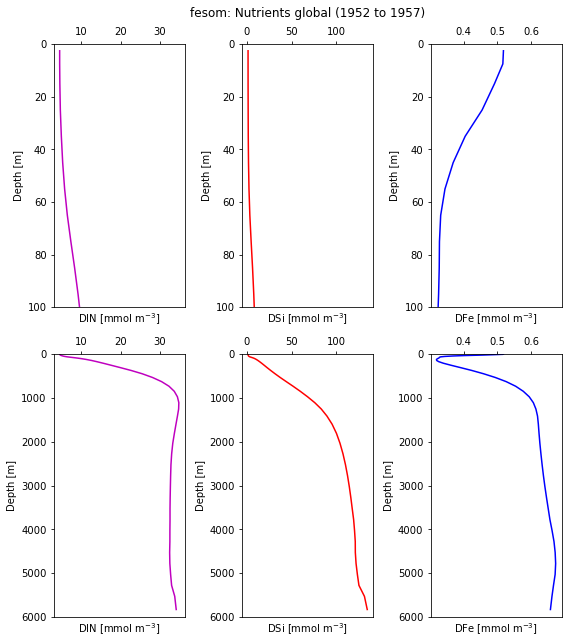

Plotting transect at lat -80 to 80, lon -25 to -25


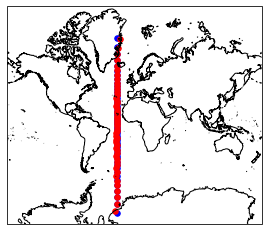

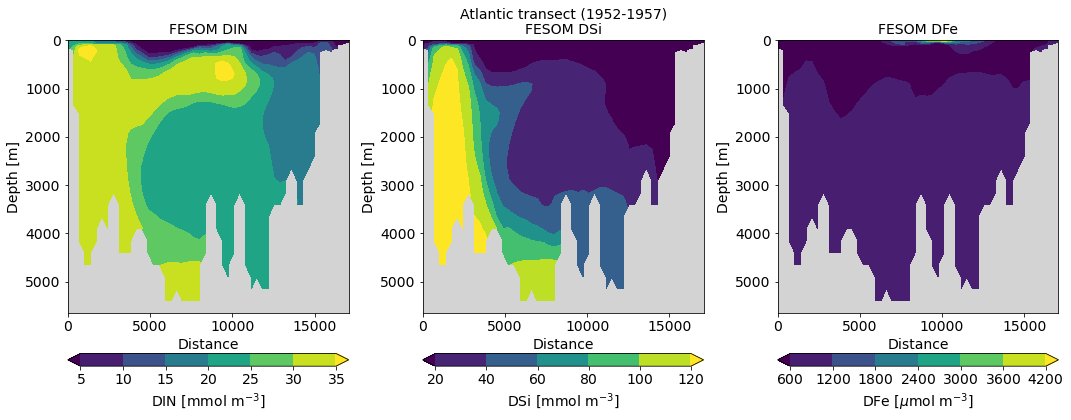

In [17]:
!jupyter nbconvert --to=python Nutrients_depth_python3.ipynb
from Nutrients_depth_python3 import Nut_depth

test = Nut_depth(runid,resultpath,savepath,meshpath,obspath,first_year,last_year,mapproj=mapproj,
                 latminmax=[-90,90],savefig=savefig)

# Carbonate system

In [18]:
!jupyter nbconvert --to=python DIC_Glodap_Comparison_python3.ipynb
from DIC_Glodap_Comparison_python3 import DICcomp

test = DICcomp(runid,resultpath,savepath,meshpath,ncfileDIC,first_year,last_year,mapproj=mapproj,savefig=savefig)

[NbConvertApp] Converting notebook DIC_Glodap_Comparison_python3.ipynb to python
[NbConvertApp] Writing 17901 bytes to DIC_Glodap_Comparison_python3.py
Depth is None, 3d field will be returned


AttributeError: 'DICcomp' object has no attribute 'runid'

In [ ]:
!jupyter nbconvert --to=python Alk_Glodap_Comparison_python3.ipynb
from Alk_Glodap_Comparison_python3 import Alkcomp

test = Alkcomp(runid,resultpath,savepath,meshpath,ncfileAlk,first_year,last_year,mapproj=mapproj,savefig=savefig)

In [ ]:
!jupyter nbconvert --to=python pCO2SOCAT_python3.ipynb
from pCO2SOCAT_python3 import pCO2comp

test = pCO2comp(runid,resultpath,savepath,meshpath,ncfilepCO2,first_year,last_year,
                mapproj=mapproj,
                savefig=savefig)

In [ ]:
# there is a change of sign in the script, so that negative is CO2 uptake and positive is CO2 outgassing
!jupyter nbconvert --to=python CO2fluxSpatialTakahashi_python3.ipynb
from CO2fluxSpatialTakahashi_python3 import CO2f_Takahashi_comp

test = CO2f_Takahashi_comp(runid,resultpath,savepath,meshpath,txtfileCO2flux,first_year,last_year,
                           mapproj=mapproj,savefig=savefig)

# Global time-series

In [ ]:
# positive is CO2 uptake, negative is outgassing
!jupyter nbconvert --to=python CO2flux_TotalGlobal_python3.ipynb
from CO2flux_TotalGlobal_python3 import CO2flux_TotalGlobal

test = CO2flux_TotalGlobal(runid,resultpath,savepath,meshpath,first_year,last_year,savefig=savefig)

In [ ]:
# time-series of NPP and export production
!jupyter nbconvert --to=python NPP_TotalGlobal_python3.ipynb
from NPP_TotalGlobal_python3 import NPP_TotalGlobal

test = NPP_TotalGlobal(runid,resultpath,savepath,meshpath,first_year,last_year,savefig=savefig)

#####################################################
### what's the definition of export production??? ###
### --> detritus sinking out of 100 m depth       ###
#####################################################

# Biology - Chlorophyll, and NPP

In [ ]:
!jupyter nbconvert --to=python Chlsurf_OCCCI_Comparison_python3.ipynb
from Chlsurf_OCCCI_Comparison_python3 import Chlsurf_OCCCI_comp

test = Chlsurf_OCCCI_comp(runid,resultpath,savepath,meshpath,matfileChlsurf,first_year,last_year,
                          mapproj=mapproj,savefig=savefig)

########################################################
# check OCCCI documentation on depth range of data!
# http://www.esa-oceancolour-cci.org/
########################################################

In [ ]:
# diatom chlorophyll
#!ncdump -h $NCfesom

label='Diatom Chlorophyll {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'Chl.a [mmol m$^{-3}$]'

DiaChl = pf.get_data(resultpath, "DiaChl", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DiaChl, mapproj = mapproj, units=units, titles=label)

In [ ]:
# nanophytoplankton chlorophyll

# ChlA --> Current intracellular ChlA conc. ??????

NCfesom = resultpath + '/ChlA.mo1.1948.nc'
#!ncdump -h $NCfesom

label='Chlorophyll {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'Chl.a [mmol m$^{-3}$]'
NChl = pf.get_data(resultpath, "ChlA", years, mesh, runid=runid, how="mean", compute=True, depth=depth)

# convert FESOM CHl.a data -------------------------------------------------------------------------------------
#Chl.a : 893.509 g/mol
if True:
    conv = 893.509
    ChlAfesom = np.log10(NChl * conv)
    unitfesom = 'Chl.a [mg m$^{-3}$]'
            
fig = pf.plot(mesh, ChlAfesom, mapproj = mapproj, units=unitfesom, titles=label)


In [ ]:
# map of total Diatom NPP 

#NCfesom = resultpath + '/NPPd.mo1.1948.nc'
#!ncdump -h $NCfesom

# 12.01* data --> mg C/m2/d

label='Diatom NPP {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'Mean NPP [mg C m$^{-2}$ d$^{-1}$]'
NPPd = pf.get_data(resultpath, "NPPd", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
NPPd = NPPd * 12.01
fig = pf.plot(mesh, NPPd, mapproj = mapproj, units=units, titles=label, cmap='viridis')


In [ ]:
# map of nanophytoplankton NPP

NCfesom = resultpath + '/NPPn.mo1.1948.nc'
#!ncdump -h $NCfesom

# 12.01* data --> mg C/m2/d

label='Nanophytoplankton NPP {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'Mean NPP [mg C m$^{-2}$ d$^{-1}$]'
NPPn = pf.get_data(resultpath, "NPPn", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
NPPn = NPPn *12.01
fig = pf.plot(mesh, NPPn, mapproj = mapproj, units=units, titles=label, cmap='viridis')


In [ ]:
# total NPP
label='Total Net Primary Production {0}-{1}  at {2} m'.format(years[0],years[1],depth)
units = 'Mean total NPP [mg C m$^{-2}$ d$^{-1}$]'
NPPtot = NPPd + NPPn
fig = pf.plot(mesh, NPPtot, mapproj = mapproj, units=units, titles=label, cmap='viridis')

# Biology - intracellular C, N, Si

In [ ]:
# Phytplankton carbon

NCfesom = resultpath + '/PhyC.mo1.1948.nc'
#!ncdump -h $NCfesom

label='Phytoplankton intracell. Carbon {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'intracellular C [mmol C m$^{-3}$]'
PhyC = pf.get_data(resultpath, "PhyC", years, mesh, runid=runid, how="mean", compute=True, depth = depth)
fig = pf.plot(mesh, PhyC, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Phytplankton nitrogen

NCfesom = resultpath + '/PhyN.mo1.1948.nc'
#!ncdump -h $NCfesom

label='Phytoplankton intracell. Nitrogen {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'intracellular N [mmol C m$^{-3}$]'
PhyN = pf.get_data(resultpath, "PhyN", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, PhyN, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Diatom carbon

NCfesom = resultpath + '/DiaC.mo1.1948.nc'
#!ncdump -h $NCfesom

label='Diatom intracell. Carbon {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'intracellular C [mmol C m$^{-3}$]'
DiaC = pf.get_data(resultpath, "DiaC", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DiaC, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Diatom nitrogen

NCfesom = resultpath + '/DiaN.mo1.1948.nc'
#!ncdump -h $NCfesom

label='Diatom intracell. Nitrogen {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'intracellular N [mmol C m$^{-3}$]'
DiaN = pf.get_data(resultpath, "DiaN", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DiaN, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Diatom silicate

NCfesom = resultpath + '/DiaSi.mo1.1948.nc'
!ncdump -h $NCfesom

label='Diatom intracell. Silicate {0}-{1}'.format(years[0],years[1])
units = 'intracellular Si [mmol m$^{-3}$]'
DiaSi = pf.get_data(resultpath, "DiaSi", years, mesh, runid=runid, how="mean", compute=True, depth=depth)

try:
    print('DiaSi \nmin {0} \nmax {1} \nmean {2} '.format(np.nanmin(DiaSi), np.nanmax(DiaSi), np.nanmean(DiaSi)))
    fig = pf.plot(mesh, DiaSi, 
                  mapproj = mapproj, 
                  units=units, titles=label)
except:
    print('*** Could not print DiaSi ***')

# extra - PCHO and TEP

In [ ]:
label='Polysaccharides {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'org C [mmol m$^{-3}$]'
PCHO = pf.get_data(resultpath, "PCHO", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, PCHO, mapproj = mapproj, units=units, titles=label)

In [ ]:
label='TEP {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'TEP-C [mmol m$^{-3}$]'
TEP = pf.get_data(resultpath, "TEP", years, mesh, runid=runid, how="mean", compute=True, depth=5)
fig = pf.plot(mesh, TEP, mapproj = mapproj, units=units, titles=label)

# extra - modelled nutrients, DIC and Alk fields alone

In [ ]:
# dissolved nitrogen

NCfesom = resultpath + '/DIN.mo1.1948.nc'
#!ncdump -h $NCfesom

label='Dissolved inorganic Nitrogen {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'DIN [mmol m$^{-3}$]'
DIN = pf.get_data(resultpath, "DIN", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DIN, mapproj = mapproj, units=units, titles=label)


In [ ]:
# dissolved Si

NCfesom = resultpath + '/DSi.mo1.1948.nc'
#!ncdump -h $NCfesom

label='Dissolved Si {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'DSi [mmol m$^{-3}$]'
DSi = pf.get_data(resultpath, "DSi", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DSi, mapproj = mapproj, units=units, titles=label)


In [ ]:
# dissolved Fe

NCfesom = resultpath + '/DFe.mo1.1948.nc'
#!ncdump -h $NCfesom

label='Dissolved Fe {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'DFe [mmol m$^{-3}$]'
DFe = pf.get_data(resultpath, "DFe", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DFe, mapproj = mapproj, units=units, titles=label)


In [ ]:
# DIC

NCfesom = resultpath + '/DIC.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Dissolved inorganic Carbon {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'DIC [mmol  m$^{-3}$]'
DIC = pf.get_data(resultpath, "DIC", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DIC, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Alkalinity

NCfesom = resultpath + '/Alk.mo1.1948.nc'
#!ncdump -h $NCfesom

label='Total Alkalinity {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'TA [mmol  m$^{-3}$]'
Alk = pf.get_data(resultpath, "Alk", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, Alk, mapproj = mapproj, units=units, titles=label)


# extra - gross primary production

In [ ]:
# Diatom GPP

NCfesom = resultpath + '/GPPd.mo1.1948.nc'
#!ncdump -h $NCfesom

# 12.01* data --> mg C/m2/d

label='Mean diatom GPP {0}-{1}'.format(years[0],years[1])
units = 'GPP [mg C  m$^{-2}$ d$^{-1}$]'
GPPd = pf.get_data(resultpath, "GPPd", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
GPPd = GPPd * 12.01
fig = pf.plot(mesh, GPPd, mapproj = mapproj, units=units, titles=label)


In [ ]:
# Nanophytoplankton GPP

NCfesom = resultpath + '/GPPn.mo1.1948.nc'
#!ncdump -h $NCfesom

# 12.01* data --> mg C/m2/d

label='Mean nanophytoplankton GPP {0}-{1}'.format(years[0],years[1])
units = 'GPP [mg C  m$^{-2}$ d$^{-1}$]'
GPPn = pf.get_data(resultpath, "GPPn", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
GPPn = GPPn * 12.01
fig = pf.plot(mesh, GPPn, mapproj = mapproj, units=units, titles=label)


In [ ]:
# total GPP

label='Mean total GPP {0}-{1}'.format(years[0],years[1])
units = 'total GPP [mg C  m$^{-2}$ d$^{-1}$]'
GPPtotal = GPPn + GPPd
fig = pf.plot(mesh, GPPtotal, mapproj = mapproj, units=units, titles=label)

# Save notebook as html

In [ ]:
%autosave 2

time.sleep(15)

!jupyter nbconvert MASTER_Script_python3.ipynb --output-dir=$htmlpath --output $htmlname --to html 